In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import iminuit

In [2]:
def read_nm3(filename):
    with open(filename) as file:
        for i, line in enumerate(file):
            if i == 8:
                break

        time, pressure, flow = [], [], []
        for line in file:
            row = line.strip().split()
            time.append(float(row[0]))
            pressure.append(float(row[2]))
            flow.append(float(row[3]))

        return np.array(time), np.array(pressure), np.array(flow)

In [3]:
nm3time, nm3pressure, nm3flow = read_nm3("../penn-2020-04-22/200422_princetonmonitor.txt")

In [4]:
def read_our(filename):
    with open(filename) as file:
        time, pressure, flow = [], [], []
        for line in file:
            row = json.loads(line)
            time.append(row["t"] / 1000.0)
            pressure.append(row["P"])
            flow.append(row["F"])

        return np.array(time), np.array(pressure), np.array(flow)

In [5]:
ourtime, ourpressure, ourflow = read_our("../penn-2020-04-22/PrincetonFlowMeter_simtest.out")

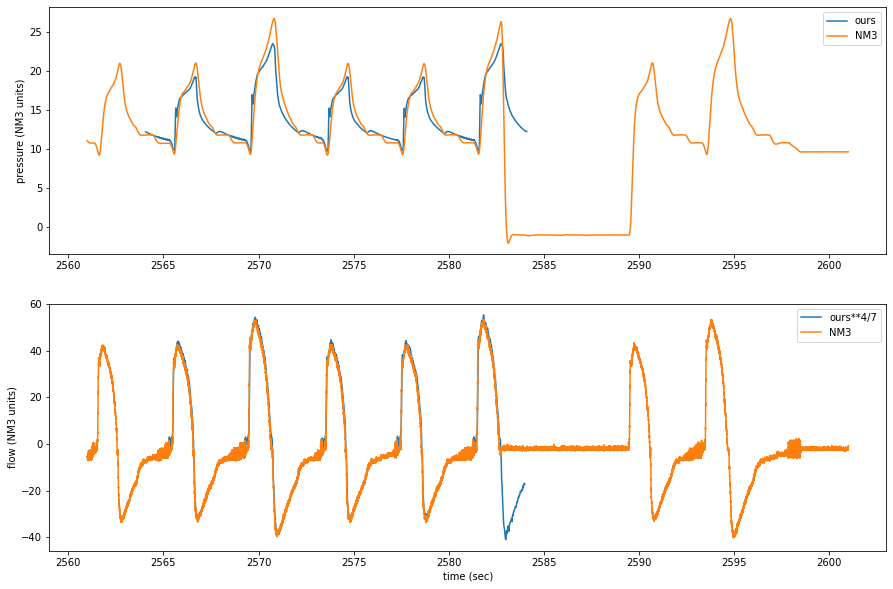

In [24]:
pressure_time_offset = -28.9
pressure_offset = -7
pressure_scale = 0.01
flow_time_offset = -29.0
flow_scale = 0.76

ourtime_part = ourtime[-11000:-10000]
ourpressure_part = ourpressure[-11000:-10000]
ourflow_part = ourflow[-11000:-10000]
nm3time_part = nm3time[-20*8000:-20*6000]
nm3pressure_part = nm3pressure[-20*8000:-20*6000]
nm3flow_part = nm3flow[-20*8000:-20*6000]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
ourhandle, = ax1.plot(ourtime_part - ourtime[0] + pressure_time_offset, pressure_scale*(ourpressure_part) + pressure_offset)
nm3handle, = ax1.plot(nm3time_part - nm3time[0], nm3pressure_part)
ax1.set_ylabel("pressure (NM3 units)")
ax1.legend([ourhandle, nm3handle], ["ours", "NM3"], loc="upper right")
ourhandle, = ax2.plot(ourtime_part - ourtime[0] + flow_time_offset, flow_scale*np.sign(ourflow_part)*abs(ourflow_part)**(4.0/7.0))
nm3handle, = ax2.plot(nm3time_part - nm3time[0], nm3flow_part)
ax2.set_ylabel("flow (NM3 units)")
ax2.set_xlabel("time (sec)")
ax2.legend([ourhandle, nm3handle], ["ours**4/7", "NM3"], loc="upper right");

In [7]:
def common_pressure(pressure_time_offset=-28.9, pressure_offset=-7, pressure_scale=0.01):
    bins = np.arange(50, 2750, 0.1)

    ourtime_fit = ourtime - ourtime[0] + pressure_time_offset
    ourpressure_fit = pressure_scale*(ourpressure) + pressure_offset
    nm3time_fit = nm3time - nm3time[0]
    nm3pressure_fit = nm3pressure

    ourindex = np.digitize(ourtime_fit, bins)
    ourpressure_numer = np.zeros(len(bins) + 1, np.float64)
    ourpressure_denom = np.zeros(len(bins) + 1, np.float64)
    ourpressure_binned = np.zeros(len(bins) + 1, np.float64)
    np.add.at(ourpressure_numer, ourindex, ourpressure_fit)
    np.add.at(ourpressure_denom, ourindex, 1)
    np.true_divide(ourpressure_numer, ourpressure_denom, out=ourpressure_binned, where=(ourpressure_denom != 0))

    nm3index = np.digitize(nm3time_fit, bins)
    nm3pressure_numer = np.zeros(len(bins) + 1, np.float64)
    nm3pressure_denom = np.zeros(len(bins) + 1, np.float64)
    nm3pressure_binned = np.zeros(len(bins) + 1, np.float64)
    np.add.at(nm3pressure_numer, nm3index, nm3pressure_fit)
    np.add.at(nm3pressure_denom, nm3index, 1)
    np.true_divide(nm3pressure_numer, nm3pressure_denom, out=nm3pressure_binned, where=(nm3pressure_denom != 0))
    
    return bins, ourpressure_binned[:-1], nm3pressure_binned[:-1]

In [8]:
def common_flow(flow_time_offset=-29.0, flow_scale=0.76):
    bins = np.arange(50, 2750, 0.1)

    ourtime_fit = ourtime - ourtime[0] + flow_time_offset
    ourflow_fit = flow_scale*np.sign(ourflow)*abs(ourflow)**(4.0/7.0)
    nm3time_fit = nm3time - nm3time[0]
    nm3flow_fit = nm3flow

    ourindex = np.digitize(ourtime_fit, bins)
    ourflow_numer = np.zeros(len(bins) + 1, np.float64)
    ourflow_denom = np.zeros(len(bins) + 1, np.float64)
    ourflow_binned = np.zeros(len(bins) + 1, np.float64)
    np.add.at(ourflow_numer, ourindex, ourflow_fit)
    np.add.at(ourflow_denom, ourindex, 1)
    np.true_divide(ourflow_numer, ourflow_denom, out=ourflow_binned, where=(ourflow_denom != 0))

    nm3index = np.digitize(nm3time_fit, bins)
    nm3flow_numer = np.zeros(len(bins) + 1, np.float64)
    nm3flow_denom = np.zeros(len(bins) + 1, np.float64)
    nm3flow_binned = np.zeros(len(bins) + 1, np.float64)
    np.add.at(nm3flow_numer, nm3index, nm3flow_fit)
    np.add.at(nm3flow_denom, nm3index, 1)
    np.true_divide(nm3flow_numer, nm3flow_denom, out=nm3flow_binned, where=(nm3flow_denom != 0))
    
    return bins, ourflow_binned[:-1], nm3flow_binned[:-1]

In [ ]:
def preschi2(pressure_time_offset=-28.9, pressure_offset=-7, pressure_scale=0.01):
    t, x, y = common_pressure(pressure_time_offset, pressure_offset, pressure_scale)
    return np.sum((x - y)**2)

presminuit = iminuit.Minuit(preschi2,
                            pressure_time_offset=-28.9,
                            pressure_offset=-7,
                            pressure_scale=0.01,
                            error_pressure_time_offset=0.1,
                            error_pressure_offset=1,
                            error_pressure_scale=0.001,
                            errordef=1)
presminuit.migrad()

In [14]:
presminuit.values

<ValueView of Minuit at 56524acb1a50>
  pressure_time_offset: -28.780866258997023
  pressure_offset: -12.733367855117836
  pressure_scale: 0.012647602421258989

In [15]:
presminuit.errors

<ErrorView of Minuit at 56524acb1a50>
  pressure_time_offset: 7.179212769853028e-08
  pressure_offset: 0.02402714955855508
  pressure_scale: 1.341381560681617e-05

**Conclusion:** `(NM3 pressure) = 0.0126 (our pressure) - 12.73`

In [ ]:
def flowchi2(flow_time_offset=-29.0, flow_scale=0.76):
    t, x, y = common_flow(flow_time_offset, flow_scale)
    return np.sum((x - y)**2)

flowminuit = iminuit.Minuit(flowchi2,
                            flow_time_offset=-29.0,
                            flow_scale=0.76,
                            error_flow_time_offset=0.1,
                            error_flow_scale=0.05,
                            errordef=1)
flowminuit.migrad()

In [16]:
flowminuit.values

<ValueView of Minuit at 56524ab62d40>
  flow_time_offset: -28.989909523855612
  flow_scale: 0.7197953928599752

In [17]:
flowminuit.errors

<ErrorView of Minuit at 56524ab62d40>
  flow_time_offset: 2.5535104898372527e-06
  flow_scale: 0.00020916532261528915

**Conclusion:** `(NM3 flow) = 0.7198 (our delta pressure)**(4/7)`

In [23]:
ptime, pour, pnm3 = common_pressure(presminuit.values["pressure_time_offset"],
                                    presminuit.values["pressure_offset"],
                                    presminuit.values["pressure_scale"])
ftime, four, fnm3 = common_flow(flowminuit.values["flow_time_offset"],
                                flowminuit.values["flow_scale"])

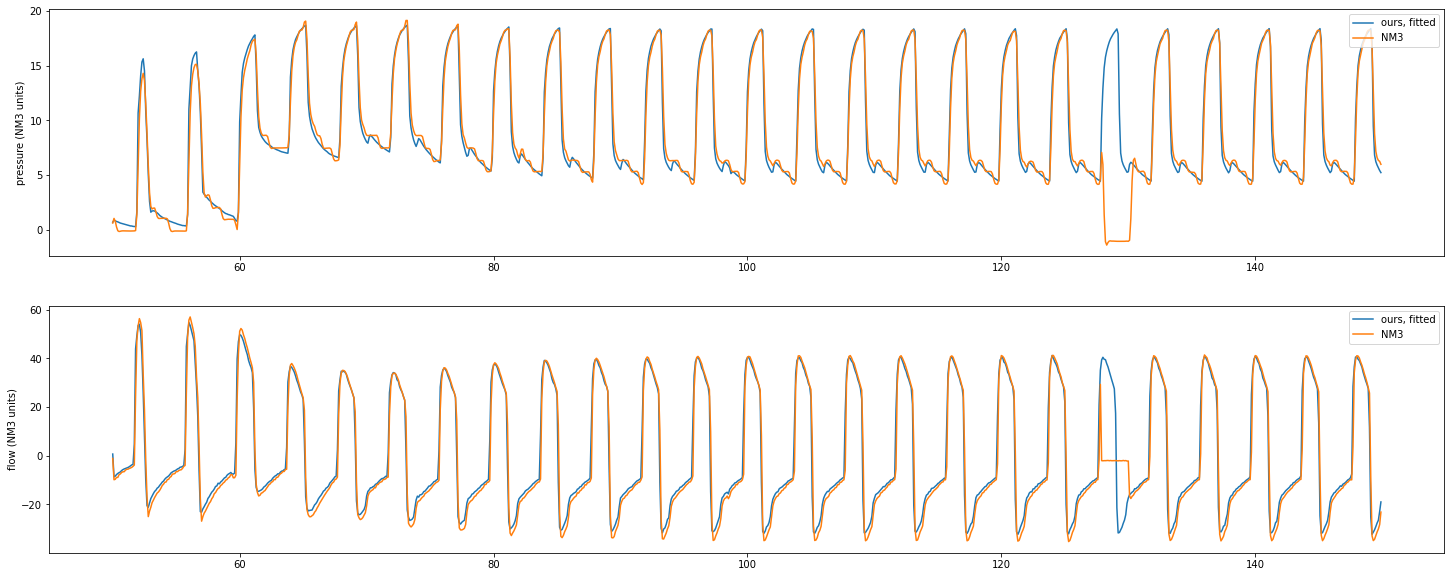

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 10))
ourhandle, = ax1.plot(ptime[:1000], pour[:1000])
nm3handle, = ax1.plot(ptime[:1000], pnm3[:1000])
ax1.set_ylabel("pressure (NM3 units)")
ax1.legend([ourhandle, nm3handle], ["ours, fitted", "NM3"], loc="upper right")

ourhandle, = ax2.plot(ftime[:1000], four[:1000])
nm3handle, = ax2.plot(ftime[:1000], fnm3[:1000])
ax2.set_ylabel("flow (NM3 units)")
ax2.legend([ourhandle, nm3handle], ["ours, fitted", "NM3"], loc="upper right");

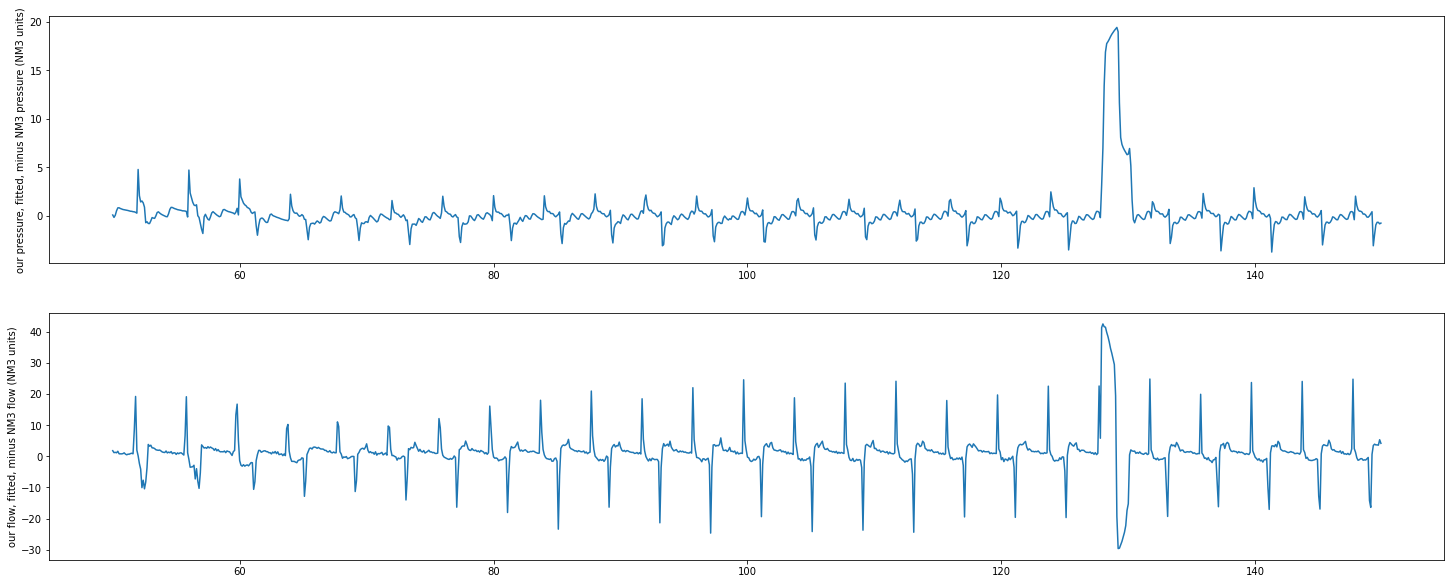

In [43]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 10))
ax1.plot(ptime[:1000], pour[:1000] - pnm3[:1000])
ax1.set_ylabel("our pressure, fitted, minus NM3 pressure (NM3 units)")

ax2.plot(ftime[:1000], four[:1000] - fnm3[:1000])
ax2.set_ylabel("our flow, fitted, minus NM3 flow (NM3 units)");

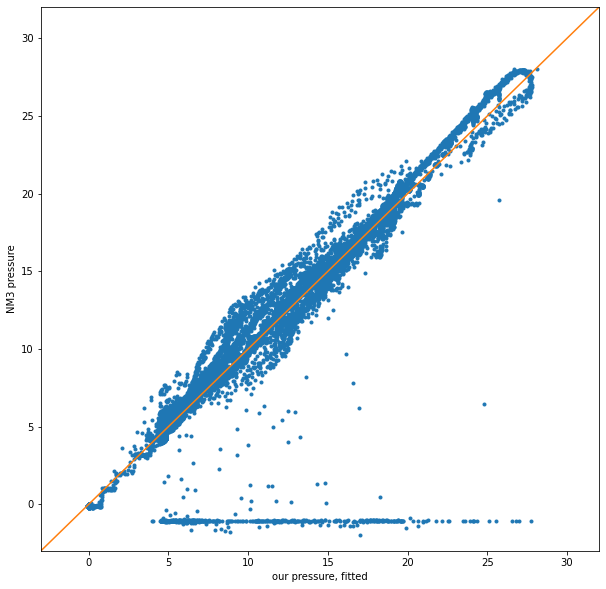

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(pour, pnm3, ".")
ax.set_xlim(-3, 32)
ax.set_ylim(-3, 32)
ax.plot([-3, 32], [-3, 32])
ax.set_xlabel("our pressure, fitted")
ax.set_ylabel("NM3 pressure");

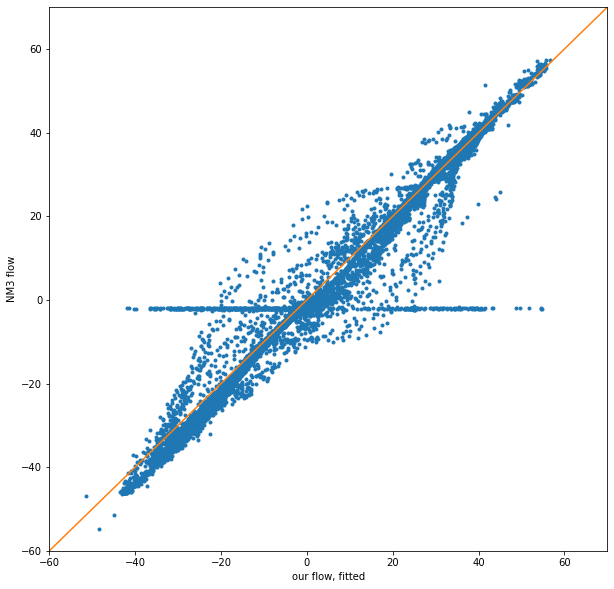

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(four, fnm3, ".")
ax.set_xlim(-60, 70)
ax.set_ylim(-60, 70)
ax.plot([-60, 70], [-60, 70])
ax.set_xlabel("our flow, fitted")
ax.set_ylabel("NM3 flow");

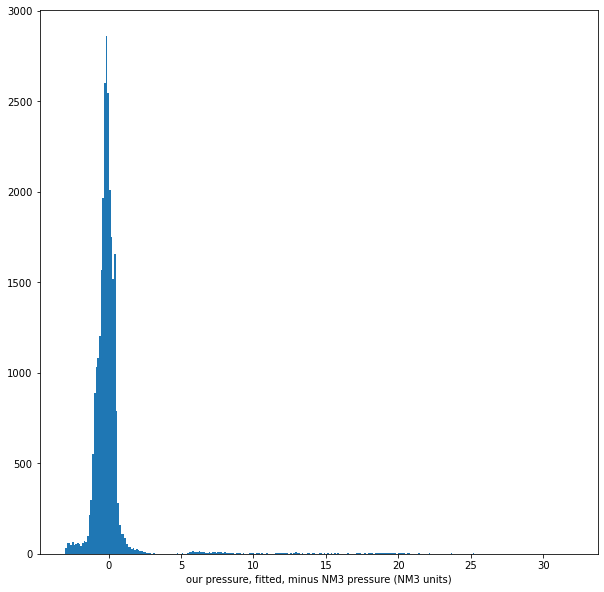

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.hist(pour - pnm3, bins=300, range=(-3, 32))
ax.set_xlabel("our pressure, fitted, minus NM3 pressure (NM3 units)");

In [51]:
np.mean(pour - pnm3), np.std(pour - pnm3)

(6.300530630883091e-09, 1.8492497485063912)

The mean is zero by construction (the fit).

In [52]:
np.std(pour - pnm3) / max(abs(np.max(pour)), abs(np.max(pnm3)))

0.06577395978374165

**Conclusion:** The standard deviation difference between our pressure measurements and NM3's is 6.5% of maximum.

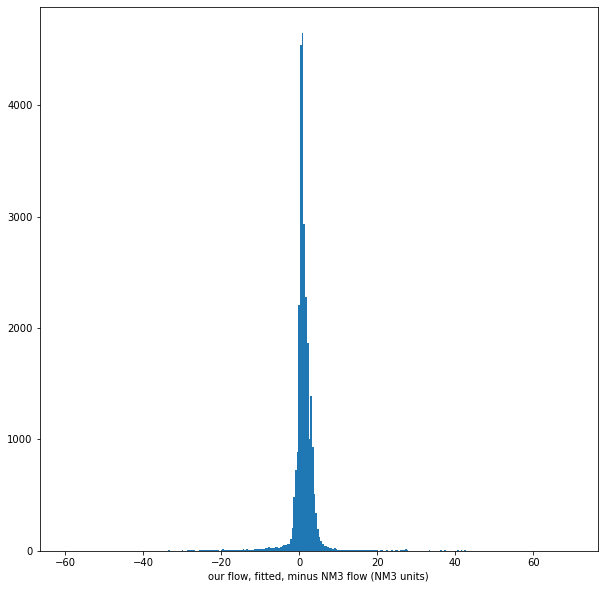

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.hist(four - fnm3, bins=300, range=(-60, 70))
ax.set_xlabel("our flow, fitted, minus NM3 flow (NM3 units)");

In [53]:
np.mean(four - fnm3), np.std(four - fnm3)

(1.1673931561842148, 3.8321021973198226)

The mean is underconstrained in the fit (scale only, no offset).

In [54]:
np.std(four - fnm3) / max(abs(np.max(four)), abs(np.max(fnm3)))

0.0667192373769694

**Conclusion:** The standard deviation difference between our flow measurements and NM3's is 6.7% of maximum.